### Import dependencies

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import nltk

In [6]:
np.version.version

'1.19.0'

In [7]:
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

### Load dataset

In [8]:
data=pd.read_csv('datasets/tweets.csv')

### Remove specific words from stopword list

In [9]:
#get stopword list
sw_list=stopwords.words('english')
sw_list.remove('not')
sw_list.remove('no')
sw_list.remove('against')

### Cleaning tweets

In [10]:
#Initialize lemmatizer
lemmatizer=WordNetLemmatizer()

In [11]:
# Get nltk wordnet tag for a given token
def nltk_wn_tag(nltk_tag):
  if nltk_tag.startswith('J'):
    return wordnet.ADJ
  elif nltk_tag.startswith('V'):
    return wordnet.VERB
  elif nltk_tag.startswith('N'):
    return wordnet.NOUN
  elif nltk_tag.startswith('R'):
    return wordnet.ADV
  else:                    
    return None

In [12]:
# Lemmatize input sentence
def lemmatize_sentence(sentence):
    tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    wordnet_tagged = map(lambda x: (x[0], nltk_wn_tag(x[1])), tagged)
    lemmatized_words=[]
    for word, tag in wordnet_tagged:
        if word not in sw_list:
            if tag is None:                        
                lemmatized_words.append(word)
            else:
                lemmatized_words.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_words)

In [13]:
# Function to clean the tweet
def clean_tweets(tweet):
    #remove RT(retweet tag)
    tweet=re.sub(r"RT @","@",tweet)
    #remove pings
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    #remove URLs
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
    #remove special characters
    tweet = re.sub(r"[^a-zA-Z]", ' ', tweet)
    #convert to lower case
    tweet=tweet.lower()
    #remove extra white spaces
    tweet = re.sub(r" +",' ', tweet)
    #lemmatization of tweet and removing stopwords
    lemmatized_tweet=lemmatize_sentence(tweet)
    #remove extra white spaces
    tweet = re.sub(r" +", ' ', tweet)
    return lemmatized_tweet.strip()

In [14]:
# Clean all tweets in dataset
data['tweets']=[clean_tweets(tweet) for tweet in data['tweets']]

### Checking and Discarding tweets left empty after cleaning (tweets that contained only retweets, pings and URLs) 

In [15]:
data.replace("",np.nan,inplace=True)
data.dropna(subset=['tweets'],inplace=True)
data.eq('').sum()

tweets    0
labels    0
dtype: int64

### Train-Test split

In [16]:
from sklearn.model_selection import train_test_split
X=data['tweets']
y=data['labels']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=7)

In [17]:
max_len=max(len(tweet.split(' ')) for tweet in X_train)

In [18]:
max_len

24

### Convert y_train and y_test to multi-class categorical format

In [19]:
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(y_train,3)
y_test=to_categorical(y_test,3)

### Create tensorboard callback

In [20]:
from tensorflow.keras.callbacks import TensorBoard

In [21]:
log_directory = 'logs-tf-embed-1\\fit'

board_1 = TensorBoard(log_dir=log_directory,histogram_freq=0,
    write_graph=True)

## Creating model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

### Create tensorflow Text Vectorizer

In [23]:
text_vectorizer = TextVectorization(max_tokens=None,
                                    output_mode="int",
                                    output_sequence_length=max_len)

In [24]:
#Fit text vectorizer to train data
text_vectorizer.adapt(X_train.values)

In [25]:
from tensorflow.keras import layers

In [26]:
len(text_vectorizer.get_vocabulary())

2485

### Create tensorflow Embedding layer

In [27]:
embedding=layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()),
                            output_dim=128,
                            embeddings_initializer='uniform',
                            input_length=max_len)
embedding

### Create and fit model

In [28]:
model_1=Sequential()
model_1.add(layers.Input(shape=(1,),dtype="string")) # Input layer to allow string inputs
model_1.add(text_vectorizer)
model_1.add(embedding)
model_1.add(layers.GlobalAveragePooling1D()) # Pooling layer to reduce the dimensionality of data
model_1.add(layers.Dense(activation='relu',units=64))
model_1.add(layers.Dropout(0.2))
model_1.add(layers.Dense(activation='relu',units=32))
model_1.add(layers.Dense(activation='softmax',units=3))
model_1.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [29]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           318080    
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 9

In [30]:
#Setting test data as validation data to see how the model performs on the test data over training period
model_1_history = model_1.fit(X_train,y_train,
                              epochs=20,
                              validation_data=(X_test,y_test), 
                              callbacks=[board_1])

Epoch 1/20
 1/34 [..............................] - ETA: 0s - loss: 1.1007 - accuracy: 0.3125WARNING:tensorflow:From C:\Users\varun\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
34/34 [==============================] - 1s 30ms/step - loss: 0.8843 - accuracy: 0.6719 - val_loss: 0.7729 - val_accuracy: 0.6691
Epoch 2/20
34/34 [==============================] - 0s 10ms/step - loss: 0.7234 - accuracy: 0.6848 - val_loss: 0.6933 - val_accuracy: 0.6765
Epoch 3/20
34/34 [==============================] - 0s 11ms/step - loss: 0.6319 - accuracy: 0.7392 - val_loss: 0.6076 - val_accuracy: 0.7794
Epoch 4/20
34/34 [==============================] - 0s 9ms/step - loss: 0.5161 - accuracy: 0.8065 - val_loss: 0.5440 - val_accuracy: 0.8051
Epoch 5/20
34/34 [==============================] - 0s 9ms/st

### Evaluate Model

### Get predictions on test data

In [31]:
y_predictions=(model_1.predict(X_test) > 0.5).astype("int32")

In [32]:
y_test.shape

(272, 3)

In [33]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(classification_report(y_test,y_predictions))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       182
           1       0.73      0.72      0.72        78
           2       1.00      0.33      0.50        12

   micro avg       0.83      0.83      0.83       272
   macro avg       0.87      0.65      0.70       272
weighted avg       0.83      0.83      0.82       272
 samples avg       0.83      0.83      0.83       272



### Get accuracy score

In [34]:
print(accuracy_score(y_test,y_predictions))

0.8272058823529411


In [35]:
losses=pd.DataFrame(model_1_history.history)

### Plot losses and accuracy

<AxesSubplot:>

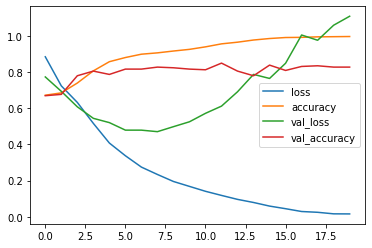

In [36]:
losses.plot()

## Create Model with EarlyStopping

### Create earlystop callback

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

In [38]:
early_stop=EarlyStopping(monitor='val_loss',patience=2)

### Create new tensorboard callback

In [39]:
log_directory = 'logs-tf-embed-2\\fit'

board_2 = TensorBoard(log_dir=log_directory,histogram_freq=0,
    write_graph=True)

In [40]:
model_2=Sequential()
model_2.add(layers.Input(shape=(1,),dtype="string")) # Input layer to allow string inputs
model_2.add(text_vectorizer)
model_2.add(embedding)
model_2.add(layers.GlobalAveragePooling1D()) # Pooling layer to reduce the dimensionality of data
model_2.add(layers.Dense(activation='relu',units=64))
model_2.add(layers.Dropout(0.2))
model_2.add(layers.Dense(activation='relu',units=32))
model_2.add(layers.Dense(activation='softmax',units=3))
model_2.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [41]:
#Setting test data as validation data to see how the model performs on the test data over training period
model_2_history = model_2.fit(X_train,y_train,
                              epochs=20,
                              validation_data=(X_test,y_test), 
                              callbacks=[board_2,early_stop])

Epoch 1/20
34/34 [==============================] - 3s 84ms/step - loss: 0.7377 - accuracy: 0.7770 - val_loss: 0.5778 - val_accuracy: 0.7868
Epoch 2/20
34/34 [==============================] - 0s 12ms/step - loss: 0.3584 - accuracy: 0.8820 - val_loss: 0.4791 - val_accuracy: 0.8309
Epoch 3/20
34/34 [==============================] - 0s 12ms/step - loss: 0.2150 - accuracy: 0.9263 - val_loss: 0.4922 - val_accuracy: 0.8125
Epoch 4/20
34/34 [==============================] - 0s 11ms/step - loss: 0.1390 - accuracy: 0.9521 - val_loss: 0.5005 - val_accuracy: 0.8456


### Evaluate model

In [42]:
y_predictions=(model_2.predict(X_test) > 0.5).astype("int32")

In [43]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(classification_report(y_test,y_predictions))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       182
           1       0.80      0.73      0.77        78
           2       1.00      0.25      0.40        12

   micro avg       0.85      0.84      0.85       272
   macro avg       0.89      0.64      0.69       272
weighted avg       0.86      0.84      0.84       272
 samples avg       0.84      0.84      0.84       272



In [44]:
print(accuracy_score(y_test,y_predictions))

0.8419117647058824


In [45]:
losses=pd.DataFrame(model_2_history.history)

### Plot losses

<AxesSubplot:>

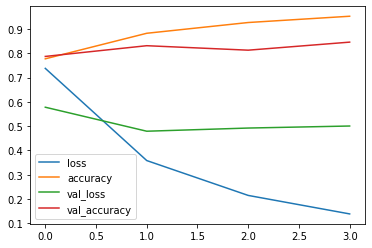

In [46]:
losses.plot()

## Creating LSTM model

### Tensorboard callback

In [94]:
log_directory = 'logs-LSTM\\fit'

board_3 = TensorBoard(log_dir=log_directory,histogram_freq=0,
    write_graph=True)

### Define model

In [95]:
model_3=Sequential()
model_3.add(layers.Input(shape=(1,),dtype="string")) # Input layer to allow string inputs
model_3.add(text_vectorizer)
model_3.add(embedding)
#No reshaping needed as LSTM expects 3 dimensional data
model_3.add(layers.LSTM(units=50))
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(activation='softmax',units=3))
model_3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

### Fit model

In [96]:
#Setting test data as validation data to see how the model performs on the test data over training period
model_3_history = model_3.fit(X_train,y_train,
                              epochs=20,
                              validation_data=(X_test,y_test),
                              callbacks=[board_3])

Epoch 1/20
34/34 [==============================] - 3s 87ms/step - loss: 0.5367 - accuracy: 0.8000 - val_loss: 0.7739 - val_accuracy: 0.7574
Epoch 2/20
34/34 [==============================] - 0s 12ms/step - loss: 0.1341 - accuracy: 0.9530 - val_loss: 0.8827 - val_accuracy: 0.8015
Epoch 3/20
34/34 [==============================] - 0s 12ms/step - loss: 0.0614 - accuracy: 0.9816 - val_loss: 0.9303 - val_accuracy: 0.8272
Epoch 4/20
34/34 [==============================] - 0s 15ms/step - loss: 0.0251 - accuracy: 0.9945 - val_loss: 1.0337 - val_accuracy: 0.8272
Epoch 5/20
34/34 [==============================] - 1s 16ms/step - loss: 0.0102 - accuracy: 0.9982 - val_loss: 1.2050 - val_accuracy: 0.8235
Epoch 6/20
34/34 [==============================] - 0s 13ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.4037 - val_accuracy: 0.8382
Epoch 7/20
34/34 [==============================] - 0s 12ms/step - loss: 3.3627e-04 - accuracy: 1.0000 - val_loss: 1.6387 - val_accuracy: 0.8346
Epoch 8/2

### Evaluate Model

In [97]:
y_predictions=(model_2.predict(X_test) > 0.5).astype("int32")

In [98]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(classification_report(y_test,y_predictions))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       182
           1       0.77      0.71      0.74        78
           2       0.00      0.00      0.00        12

   micro avg       0.83      0.83      0.83       272
   macro avg       0.54      0.55      0.54       272
weighted avg       0.79      0.83      0.81       272
 samples avg       0.83      0.83      0.83       272



In [99]:
print(accuracy_score(y_test,y_predictions))

0.8308823529411765


In [100]:
losses=pd.DataFrame(model_3_history.history)

### Plot Losses

<AxesSubplot:>

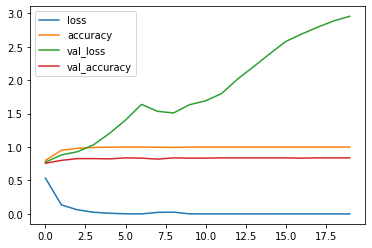

In [101]:
losses.plot()